In [93]:
!pip install python-dotenv strands-agents[mistral] strands-agents-tools tqdm mistralai tiktoken

In [94]:
pip list | grep mistralai

mistralai                               1.9.10
Note: you may need to restart the kernel to use updated packages.


# 🧠📉 Onboarding Notebook — Eco- & Cost-Efficient Use of Mistral LLM via *La Plateforme* 
> Version generated on 2025-09-09


Welcome! This notebook is part of the training material for your **data science challenge**.

**Context:** You will build a solution that interacts with **100 personas** (simulated by LLMs) in natural language to guide their professional career. Each persona has an associated **gold file** describing the ground-truth recommendations your solution should steer them toward.

**Goal:** Help you use Mistral LLM efficiently — minimizing **cost**, **latency**, and **environmental impact** while keeping outputs reliable and reproducible for **testing vs. final submission**.



## 0) Prerequisites

- **Account** and **API key** for Mistral (*La Plateforme*). Store it in the environment variable `MISTRAL_API_KEY`.
- Python ≥ 3.9, and (optionally) these packages:
```bash
pip install mistralai python-dotenv pandas matplotlib 
```


## 1) Setup: API key, client, quick verification

In [95]:

import os
from dataclasses import dataclass
from dotenv import load_dotenv

load_dotenv("../env")
API_KEY = os.getenv("MISTRAL_API_KEY")
if not API_KEY:
    raise RuntimeError("⚠️ Please set MISTRAL_API_KEY in your environment or a .env file.")

try:
    from mistralai import Mistral
except Exception as e:
    raise RuntimeError("Install the SDK first: pip install mistralai") from e

client = Mistral(api_key=API_KEY)

# Optional: list available models (fallback to a known one if unavailable)
try:
    available_models = [m.id for m in client.models.list().data]  # type: ignore
    print("✅ Available models:", available_models)
except Exception:
    print("ℹ️ Could not list models; proceed with a known one (e.g., 'mistral-small-latest').")


✅ Available models: ['mistral-medium-2505', 'mistral-large-latest', 'mistral-medium-2508', 'mistral-medium-latest', 'mistral-medium', 'ministral-3b-2410', 'ministral-3b-latest', 'ministral-8b-2410', 'ministral-8b-latest', 'open-mistral-7b', 'mistral-tiny', 'mistral-tiny-2312', 'open-mistral-nemo', 'open-mistral-nemo-2407', 'mistral-tiny-2407', 'mistral-tiny-latest', 'open-mixtral-8x7b', 'mistral-small', 'mistral-small-2312', 'open-mixtral-8x22b', 'open-mixtral-8x22b-2404', 'mistral-small-2409', 'mistral-large-2407', 'mistral-large-2411', 'pixtral-large-2411', 'pixtral-large-latest', 'mistral-large-pixtral-2411', 'codestral-2501', 'codestral-2412', 'codestral-2411-rc5', 'codestral-2508', 'codestral-latest', 'devstral-small-2505', 'devstral-small-2507', 'devstral-small-latest', 'devstral-medium-2507', 'devstral-medium-latest', 'pixtral-12b-2409', 'pixtral-12b', 'pixtral-12b-latest', 'mistral-small-2501', 'mistral-small-2503', 'mistral-small-2506', 'mistral-small-latest', 'mistral-saba-25


## 2) Efficiency Principles (cost, latency, energy)

1. **Start small**: prototype with a *small* model first; scale only if needed.  
2. **Strict bounds**: set conservative `max_tokens` and increase only with evidence.  
3. **Concise prompts**: bullet points, explicit schemas, JSON output.  
4. **Stop sequences**: stop generation when your structure is complete.  
5. **Caching**: cache stable prompts and documents; hash inputs.  
6. **Measure**: track tokens/latency/errors; **enforce budgets**.  
7. **Determinism**: low temperature; seed if supported; avoid redundant retries.  
8. **Clean inputs**: remove noise and unnecessary history.
9. **Carbon aware scheduling**:Schedule heavy runs during low-carbon hours (e.g., nighttime or weekends in your region) if using cloud infrastructure. This can reduce environmental impact when used at scale.
10. **Submission fingerprinting**:Include model version, temperature, token usage, and prompt hash. This helps with reproducibility and auditability without storing full logs.


## 3) Minimal call with strict token control

In [96]:

"""This snippet shows how to make a safe, efficient, and reproducible call to the Mistral LLM using a structured prompt and 
controlled generation settings.

What the Code Does:
Defines a system prompt that sets clear behavior: concise answers under 60 words, and honesty when uncertain.

Sends a user query asking why limiting max_tokens is important.

Calls the Mistral model with:

max_tokens=120: limits the length of the response to control cost and latency.
temperature=0.2: encourages deterministic, focused output.
top_p=0.9: controls diversity of output (optional).
(Optional) stop and response_format parameters for cleaner output or structured JSON.
Prints the model’s reply and usage stats:

prompt_tokens: tokens used in the input
completion_tokens: tokens used in the output
total_tokens: total cost-relevant token count
"""

from mistralai import Mistral

MODEL_SMALL = "mistral-small-latest"  # adjust to your org's models

system = "You are a concise assistant. Answer in <60 words. If unsure, say so."
user = "Explain why limiting max_tokens is important when calling an LLM."

resp = client.chat.complete(
    model=MODEL_SMALL,
    messages=[
        {"role": "system", "content": system},
        {"role": "user", "content": user}
    ],
    max_tokens=120,
    temperature=0.2,
    top_p=0.9,
    # stop=["\nEND"]  # add if you know your stopping delimiter
    # response_format={"type":"json_object"}  # add if you want JSON
)

print(resp.choices[0].message.content)   # type: ignore
print("usage:", resp.usage)  # prompt_tokens, completion_tokens, total_tokens


Limiting max_tokens prevents excessively long responses, saving computational resources and time. It also helps maintain context relevance and avoids unnecessary verbosity. However, setting it too low may truncate important information. Balance is key.
usage: prompt_tokens=38 completion_tokens=44 total_tokens=82 prompt_audio_seconds=Unset()


## 4) Compact JSON output (less verbosity, easier post-processing)

In [97]:
"""This code demonstrates how to request structured output from the Mistral LLM using the response_format={"type": "json_object"} parameter.

What the Code Does:
Defines a prompt asking the model to give 3 reasons to reduce token usage, and to reply in a specific JSON format.
Sends the prompt to the Mistral model (MODEL_SMALL) with:
max_tokens=120: limits the response length.
temperature=0.2: ensures low variability for reproducibility.
response_format={"type": "json_object"}: instructs the model to return a valid JSON object.
Prints the model’s response and the token usage metadata."""

import hashlib
import json
import os
import time

# Define the cache directory
CACHE_DIR = "../mistral_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

# Generate a unique cache key based on model, messages, and other parameters
def _cache_key(model: str, messages: list, **kwargs) -> str:
    blob = json.dumps({"model": model, "messages": messages, **kwargs}, sort_keys=True).encode()
    return hashlib.sha256(blob).hexdigest()

# Main function to handle caching logic
def chat_with_cache(model: str, messages: list, **kwargs):
    print("Start")
    key = _cache_key(model, messages, **kwargs)
    path = os.path.join(CACHE_DIR, key)

    # Check if response is already cached
    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
        data["from_cache"] = True
        return data

    # If not cached, call the Mistral API
    out = client.chat.complete(model=model, messages=messages, **kwargs)
    data = {
        "content": out.choices[0].message.content,
        "usage": getattr(out, "usage", None),
        "created": int(time.time())
    }

    # Convert usage object to dictionary if needed
    if data["usage"] and hasattr(data["usage"], '__dict__'):
        data["usage"] = data["usage"].__dict__

    # Save to cache
    with open(path, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

    data["from_cache"] = False
    return data
    print("Done")

## 5) Simple local cache (avoid unnecessary model calls)

In [98]:
"""
This utility caches responses from a language model (LLM) locally to avoid repeated API calls during development and testing. 
It helps reduce latency, cost, and environmental impact while ensuring consistent behavior across identical inputs.

What the Code Does:
- Creates a local cache directory (`.mistral_cache`) to store model responses.
- Generates a unique cache key using a SHA-256 hash of:
  • Model name
  • Message history
  • Additional parameters (e.g., temperature, max_tokens)
- Checks if a cached response exists:
  • If found, loads it from disk and marks it as `"from_cache": True`
  • If not found, calls the Mistral API, saves the response, and marks it as `"from_cache": False`
- Returns the response content along with usage metadata (e.g., token counts)

This approach is especially useful during iterative prompt tuning, model evaluation, or experimentation in data science workflows.
"""
import hashlib
import json
import os
import time
CACHE_DIR = ".mistral_cache"
os.makedirs(CACHE_DIR, exist_ok=True)
def _cache_key(model: str, messages: list, **kwargs) -> str:
    blob = json.dumps({"model": model, "messages": messages, **kwargs}, sort_keys=True).encode()
    return hashlib.sha256(blob).hexdigest()
def chat_with_cache(model: str, messages: list, **kwargs):
    key = _cache_key(model, messages, **kwargs)
    path = os.path.join(CACHE_DIR, key + ".json")
    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
        data["from_cache"] = True
        return data
    out = client.chat.complete(model=model, messages=messages, **kwargs)
    # Safely serialize usage
    usage = getattr(out, "usage", None)
    if usage:
        try:
            usage = json.loads(json.dumps(usage, default=lambda o: o.__dict__))
        except Exception:
            usage = str(usage)
    data = {
        "content": out.choices[0].message.content,
        "usage": usage,
        "created": int(time.time()),
        "from_cache": False
    }
    with open(path, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)
    return data


## 6) Track usage and enforce budgets (lightweight logging)

In [99]:

"""This code helps you track and log the usage of a language model (LLM) like Mistral during your experiments. 
It’s especially useful when you're testing prompts, measuring latency, or analyzing token consumption.

What Does This Code Do?
Defines a structure to store usage data
Logs each LLM call to a CSV file
Wraps the LLM call in a safe function that handles errors and logs performance
"""

import csv, time
from pathlib import Path
from dataclasses import dataclass


LOG_PATH = Path("mistral_usage_log.csv")

@dataclass
class UsageRecord:
    ts: float
    model: str
    prompt_tokens: int
    completion_tokens: int
    total_tokens: int
    latency_s: float
    ok: bool

def log_usage(rec: UsageRecord):
    exists = LOG_PATH.exists()
    with open(LOG_PATH, "a", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        if not exists:
            w.writerow(["ts","model","prompt_tokens","completion_tokens","total_tokens","latency_s","ok"])
        w.writerow([rec.ts, rec.model, rec.prompt_tokens, rec.completion_tokens, rec.total_tokens, rec.latency_s, rec.ok])

def safe_chat(model: str, messages: list, **kwargs) -> str:
    t0 = time.time()
    try:
        out = client.chat.complete(model=model, messages=messages, **kwargs)
        latency = time.time() - t0
        # Safely convert usage to dict
        usage = getattr(out, "usage", None)
        if usage:
            try:
                usage = json.loads(json.dumps(usage, default=lambda o: o.__dict__))
            except Exception:
                usage = {}

        log_usage(UsageRecord(
            ts=time.time(),
            model=model,
            prompt_tokens=usage.get("prompt_tokens", 0),
            completion_tokens=usage.get("completion_tokens", 0),
            total_tokens=usage.get("total_tokens", 0),
            latency_s=latency,
            ok=True
        ))

        return out.choices[0].message.content  # type: ignore

    except Exception as e:
        latency = time.time() - t0
        log_usage(UsageRecord(
            ts=time.time(),
            model=model,
            prompt_tokens=0,
            completion_tokens=0,
            total_tokens=0,
            latency_s=latency,
            ok=False
        ))
        raise

# Example
txt = safe_chat(
    MODEL_SMALL,
    [{"role":"user", "content":"Reply with just 'ok'"}],
    max_tokens=3, temperature=0
)
print(txt)
print(f"Log file: {LOG_PATH.resolve()}")


ok
Log file: /home/ec2-user/SageMaker/conversations_tej/mistral_usage_log.csv


### 7)Visualize usage quickly

,ts,model,prompt_tokens,completion_tokens,total_tokens,latency_s,ok
1,1.758186e+09,mistral-small-latest,0,0,0,0.272914,False
2,1.758186e+09,mistral-small-latest,9,2,11,0.223315,True
3,1.758187e+09,mistral-small-latest,9,2,11,0.212862,True
4,1.758197e+09,mistral-small-latest,9,2,11,0.212736,True
5,1.758274e+09,mistral-small-latest,9,2,11,0.296407,True


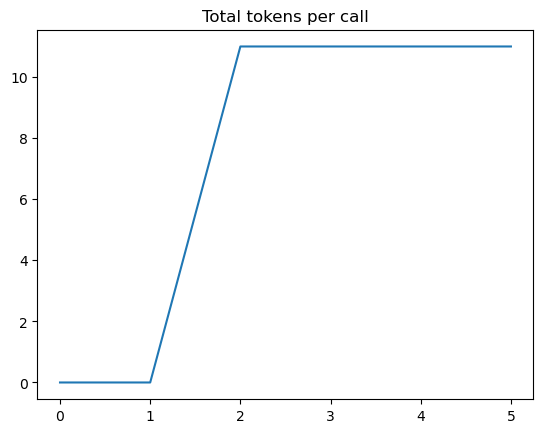

In [100]:

"""This code helps analyze your LLM usage over time by reading the mistral_usage_log.csv file and plotting how many tokens were used in each call.

What the Code Does:
Checks if the usage log file exists (mistral_usage_log.csv).
If it exists:
Loads the log into a pandas DataFrame.
Displays the last 5 entries to give a quick snapshot of recent usage.
Plots the total_tokens column to show how token usage varies across calls.
If the file doesn’t exist:
Prints a message saying no logs are available yet."""

import pandas as pd
import matplotlib.pyplot as plt

if LOG_PATH.exists():
    df = pd.read_csv(LOG_PATH)
    display(df.tail(5))
    plt.figure()
    df['total_tokens'].plot(title="Total tokens per call")
    plt.show()
else:
    print("No logs yet.")



## 8) Choosing the right model

- **Heuristic**: *small* for extraction/formatting/JSON, *medium* for moderate reasoning, *large* only if strictly necessary.  
- **Local benchmark**: create a small eval set (20–50 cases); compare **quality vs. cost/latency**.  
- **Solution profiles**: define presets (`FAST_CHEAP`, `BALANCED`, `SMART`) and **default to the frugal one**.


## 9) Robustness: timeouts, retries, exponential backoff

In [101]:

"""This code defines a retry mechanism that wraps your Mistral API call to make it more robust and fault-tolerant.
If the call fails due to a transient error (like a network glitch or rate limit), 
it will automatically retry up to 3 times using exponential backoff with jitter—a technique that increases the wait time 
between retries while adding randomness to avoid overloading the server."""

import random, time

def retry(fn, attempts=3, base=0.5, jitter=0.3):
    for i in range(attempts):
        try:
            return fn()
        except Exception:
            if i == attempts - 1:
                raise
            delay = base * (2**i) + random.uniform(0, jitter)
            time.sleep(delay)

res = retry(lambda: client.chat.complete(
    model=MODEL_SMALL,
    messages=[{"role":"user", "content":"Reply 'ok'"}],
    max_tokens=3, temperature=0
))
print(res.choices[0].message.content)  # type: ignore


ok



## 10) Governance, Security & Privacy

- **Log only essentials** (hash inputs rather than storing raw text if feasible).  
- **Guardrails**: input size limits, content filters, output JSON schema validation.  
- **Version prompts & configs** (git) and link results to artifact hashes.  
- **Separate environments** (local/submission) and API keys with roles/quotas.



## 11) (Optional) Rough environmental impact estimation

> Exact footprint of API calls is not directly observable. You can still track tokens and apply an **internal factor** (gCO₂e per 1k tokens) for relative comparisons.

Formula: `impact ≈ total_tokens × factor_gco2_per_1k`. Use for **relative** comparisons only.


In [102]:

"""This script helps track and estimate the environmental impact of Mistral LLM usage by calculating the carbon footprint based on total tokens used.
It reads mistral usage log that contains token counts per run.It applies a simple formula to estimate emissions. 
It then adds a new column est_gco2 to the log and displays the last 10 entries."""

import pandas as pd

G_CO2_PER_1K_TOKENS = 2.85   #Grams of carbon dioxide equivalent per 1000 tokens

def estimate_emissions_gco2(total_tokens:int, factor_per_1k:float=G_CO2_PER_1K_TOKENS)->float:
    return (total_tokens / 1000.0) * factor_per_1k

from pathlib import Path
LOG_PATH = Path("mistral_usage_log.csv")

if LOG_PATH.exists():
    df = pd.read_csv(LOG_PATH)
    df["est_gco2"] = df["total_tokens"].apply(estimate_emissions_gco2)
    display(df[["ts","model","total_tokens","est_gco2"]].tail(10))
    print(f"Total estimate (gCO2e): {df['est_gco2'].sum():.2f}")
else:
    print("No usage log yet.")


,ts,model,total_tokens,est_gco2
0,1.758185e+09,mistral-small-latest,0,0.00000
1,1.758186e+09,mistral-small-latest,0,0.00000
2,1.758186e+09,mistral-small-latest,11,0.03135
3,1.758187e+09,mistral-small-latest,11,0.03135
4,1.758197e+09,mistral-small-latest,11,0.03135
5,1.758274e+09,mistral-small-latest,11,0.03135


Total estimate (gCO2e): 0.13



## 12) Frugality checklist **before final submission**

- [ ] **Smallest sufficient model** is default.  
- [ ] `max_tokens` and **stop** set.  
- [ ] **JSON output** where relevant; **compact prompts**.  
- [ ] **Cache** used in local testing; **disabled for submission** (no stale answers).  
- [ ] **Budgets** in place (tokens/calls/day).  
- [ ] **Usage logging** (tokens, latency, errors) + minimal dashboard.  
- [ ] **Eval set** (20–50 cases) shows quality/cost/latency trade-offs.  
- [ ] **Privacy**: minimization, guardrails, lean logs.  
- [ ] **Retries/backoff** + **timeouts** configured.  


## 13) Assistant specifics: conversational memory & rolling summaries

In [103]:

# Token counting & rolling summary utilities
"""This utility helps track token usage and manage prompt length efficiently when working with Mistral LLM.

What it does:
Estimates token count using tiktoken to approximate how many tokens a message will consume.
Trims message history to stay within a token budget, keeping only the most relevant parts (e.g., system prompt + last user turns).
Maintains a rolling summary of the conversation using the model itself, summarizing recent turns into a compact bullet list. 
This helps reduce prompt size while preserving context."""


import tiktoken
from typing import List

ENC = tiktoken.get_encoding("cl100k_base")  # approx for counting

def approx_tokens(text: str) -> int:
    return len(ENC.encode(text))

def total_tokens_messages(msgs: List[dict]) -> int:
    return sum(approx_tokens(getattr(m, "content", "")) for m in msgs)

def trim_messages(msgs: List[dict], max_prompt_tokens: int) -> List[dict]:
    system = [m for m in msgs if m.role == "system"]
    others = [m for m in msgs if m.role != "system"]
    base = (system[:1] + others[-2:]) if len(others) >= 2 else msgs[:]
    if total_tokens_messages(base) <= max_prompt_tokens:
        return base
    return (system[:1] + [m for m in others if m.role == "user"][-1:])

ROLLING_SUMMARY = ""

def update_rolling_summary(client, model: str, msgs: List[dict]) -> str:
    global ROLLING_SUMMARY
    prompt = [
        {"role": "system", "content": "Summarize into ≤5 factual bullets, in English, no verbosity."},
        {"role": "user", "content": f"Current summary:\n{ROLLING_SUMMARY}\n\nNew turns:\n{[(m['role'], m['content']) for m in msgs[-3:]]}\n\nUpdate the summary."}
    ]
    out = client.chat.complete(model=model, messages=prompt, max_tokens=120, temperature=0.1)
    ROLLING_SUMMARY = out.choices[0].message.content  # type: ignore
    return ROLLING_SUMMARY



## 14) Minimal system prompt for assistants

Keep the **contract short** to save tokens each turn:

> *"You are a concise English assistant. Answer in ≤120 words. If a table is requested, return valid JSON `{columns:[], rows:[]}`. For code, return code only. If unsure, say so and ask one clarifying question. Use only the provided context."*
Replace verbose instructions with symbolic or shorthand cues (e.g., #plan, #tool_call) that are interpreted by the model but save tokens. This is especially useful in multi-step agentic flows.


## 15) Function-calling (if supported): minimal schemas & stop sequences

In [104]:
"""This utility defines a tool specification for reading Excel file content via a structured function call, 
enabling integration with chat-based AI systems.
What it does:
*Declares a function named get_excel_content for use in tool-based AI workflows.
*Enables reading data from an Excel file by specifying:
  -File path
  -Sheet name
  -Optional cell range (e.g., "A1:C10")
*Supports automatic tool selection (tool_choice="auto") for intelligent invocation.
*Ensures controlled output via max_tokens, temperature, and stop conditions."""

[
  {
    "type": "function",
    "function": {
      "name": "get_excel_content",
      "description": "Reads and returns content from an Excel file. You can specify sheet name and optionally a cell range.",
      "parameters": {
        "type": "object",
        "properties": {
          "file_path": {
            "type": "string",
            "description": "Path to the Excel file."
          },
          "sheet_name": {
            "type": "string",
            "description": "Name of the sheet to read from."
          },
          "range": {
            "type": "string",
            "description": "Optional cell range (e.g., 'A1:C10')."
          }
        },
        "required": ["file_path", "sheet_name"],
        "additionalProperties": "false"
      }
    }
  }
]

# Example call (adapt to your SDK version):
# resp = client.chat.complete(
#   model=MODEL_SMALL,
#   messages=[...],
#   tools=TOOLS_SPEC,
#   tool_choice="auto",
#   max_tokens=160,
#   temperature=0.2,
#   stop=["</tool_output>"]
# )


[{'type': 'function',
  'function': {'name': 'get_excel_content',
   'description': 'Reads and returns content from an Excel file. You can specify sheet name and optionally a cell range.',
   'parameters': {'type': 'object',
    'properties': {'file_path': {'type': 'string',
      'description': 'Path to the Excel file.'},
     'sheet_name': {'type': 'string',
      'description': 'Name of the sheet to read from.'},
     'range': {'type': 'string',
      'description': "Optional cell range (e.g., 'A1:C10')."}},
    'required': ['file_path', 'sheet_name'],
    'additionalProperties': 'false'}}}]

## 16) Agent observability: lean logs, metrics, and circuit breakers with submission fingerprint

In [105]:

"""This utility logs each agent run to a CSV file (agent_runs.csv) for traceability, debugging, and performance analysis.

What it does:
Records each tool invocation made during an agent run.
Captures the following details for each step:
Timestamp (in human-readable ISO format)
Run ID
Step number
Tool name
Latency (in seconds)
Total tokens used for the run
Automatically creates the CSV file with headers if it doesn't exist.
Uses structured logging via csv.DictWriter for clarity and consistency.
Includes error handling to ensure robustness during file operations."""

import csv
import time
from pathlib import Path

AGENT_LOG = Path("agent_runs.csv")

def log_agent_run(run_id: str, trace: list, used_tokens: int):
    fieldnames = ["timestamp", "run_id", "step", "tool", "latency_s", "used_tokens"]
    log_exists = AGENT_LOG.exists()

    try:
        with open(AGENT_LOG, "a", newline="", encoding="utf-8") as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            if not log_exists:
                writer.writeheader()
            for t in trace:
                writer.writerow({
                    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()),
                    "run_id": run_id,
                    "step": t.get("step"),
                    "tool": t.get("tool", ""),
                    "latency_s": t.get("latency_s", 0.0),
                    "used_tokens": used_tokens
                })
    except Exception as e:
        print(f"Error logging agent run: {e}")



In [106]:

"""This code helps you track each agent run and generate a minimal fingerprint for your final submission. 

What the Code Does:
Defines a log file (agent_runs.csv) to store metadata about each run.
Generates a SHA256 hash of the prompt using hashlib, so you don’t need to store raw prompt text.
Logs each run with:
Timestamp (ts)
Run ID (run_id)
Model name (model)
Temperature (temperature)
Total tokens used (total_tokens)
Prompt hash (prompt_hash)
Prints a fingerprint in JSON format that you can include with your final submission.
"""

import csv, time, hashlib, json
from pathlib import Path

MODEL_SMALL = "mistral-small-latest"
AGENT_LOG = Path("agent_runs.csv")

def hash_prompt(messages):
    full_prompt = "\n".join(f"{m.role}: {m.content}" for m in messages)
    return hashlib.sha256(full_prompt.encode()).hexdigest()

def log_agent_run(run_id: str, messages: list, used_tokens: int, temperature: float):
    exists = AGENT_LOG.exists()
    prompt_hash = hash_prompt(messages)
    timestamp = time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime())

    with open(AGENT_LOG, "a", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        if not exists:
            w.writerow(["ts", "run_id", "model", "temperature", "total_tokens", "prompt_hash"])
        w.writerow([timestamp, run_id, MODEL_SMALL, temperature, used_tokens, prompt_hash])

    # Optional: print fingerprint for submission
    fingerprint = {
        "model": MODEL_SMALL,
        "temperature": temperature,
        "total_tokens_used": used_tokens,
        "prompt_hash": prompt_hash
    }
    print("Submission Fingerprint:")
    print(json.dumps(fingerprint, indent=2))



## 17) Challenge specifics: **testing vs submission** with personas & gold files

- **Personas**: 100 LLM-driven personas to interact with in natural language.  
- **Gold files**: each persona has a ground-truth recommendation set your solution should surface.  
- **Testing** (local): smaller models, aggressive caching, verbose logs, sandboxed tools.  
- **Submission** (final run): deterministic settings (low temperature), **no cache reuse**, strict budgets, concise prompts, validated JSON outputs, lean logs.  
- **Evaluation tip**: build a small **offline eval set** mapping persona snippets → expected gold recommendations, measure accuracy + tokens/latency.



---

🎯 **Key takeaway**: *Start small, measure everything, enforce limits, and design for frugality from the start.*  
Good luck with the challenge!
